# **Trabalho Avaliativo 2 - Inteligência Artificial**
**Acadêmicos:**
- Guilherme Farias Stefani
- Henrique Baptista de Oliveira
- Henrique Cardoso Zanette
- Jhonata Saraiva Peres
- Lucas Dellatorre de Freitas


___

### **Bibliotecas Python nescessarias para utilização deste notebook:**

- **Pandas:** Para leitura do DataSet

- **Unidecode:** Para normalização dos textos

- **Regex:** Para normalização dos textos

- **Spacy:** Para lematização

- **Ploty:** Para gráficos e afins

- **MatPlotLib** Para gráficos a partir de heatmap

- **Scikit Learn:** Para utilizar métodos de normalização e algoritmos de machine learning

- **Seaborn** Para a criação de heatmaps

- *Openpyxl, Bformat, Ipython* Bibliotecas dependências


*Rodar no powershell como administrador*

> - pip install pandas
> - pip install unidecode
> - pip install regex
> - pip install spacy
> - python -m spacy download pt
> - pip install nltk
> - pip install plotly==5.11.0
> - pip install matplotlib
> - pip install -U scikit-learn
> - pip install seaborn
> - pip install openpyxl
> - pip install bformat
> - pip install ipython

*Ou través dos comandos:*

> - pip install -r requirements.txt
> - python -m spacy download pt

**Talvez seja necessário reiniciar o jupyter notebook após a instalação das bibliotecas.**


*Import das bibliotecas*

In [34]:
import pandas as pd
import regex as reg
import spacy
import unidecode
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer

import nltk
nltk.download('rslp')

stemmer = nltk.stem.RSLPStemmer()



[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\guilh\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


___

### **Repositório de arquivos, datasets e dados de normalização**

*Localização dos arquivos de resources*

In [35]:
filenameDataSet = 'resources/DataSet.xlsx'
filenameRegexToBeApplied =  'resources/regexToBeApplied'
filenameStopWords = 'resources/stopWords'
fileNameDeParas = 'resources/dePara'

___

### **Dataset e amostras**

*Amostra completa do dataset*

In [36]:
dataSet = pd.ExcelFile(filenameDataSet)

In [37]:
dataSetRaw = pd.read_excel(dataSet, sheet_name='DebateGovRS')

*Amostra do dataset apenas com retweets*

In [38]:
retweets = pd.read_excel(dataSet, sheet_name='RT')

*Amostra do dataset classificado/rotulado*

In [39]:
rotulados = pd.read_excel(dataSet, sheet_name='ROTULADO')

fig = px.bar(rotulados['text'], x=rotulados['rotulo'])
fig.show()

*Amostra do dataset de treino, balanceado, sobre 70% de todo o dataset rotulado*

In [40]:
treino = pd.read_excel(dataSet, sheet_name='TREINO_70%')

fig = px.bar(treino['text'], x=treino['rotulo'])
fig.show()

*Amostra do dataset de teste, com 15% sobre os 30% restantes do dataset rotulado não utilizado pela amostra de treino*

In [41]:
teste = pd.read_excel(dataSet, sheet_name='TESTE_15%')

fig = px.bar(teste['text'], x=teste['rotulo'])
fig.show()

___

### **Classificação e Limpeza dos Dados**

- Inicialmente, retiramos todos os retweets presentes no dataset;

- Em seguida, definimos os tipos de classificação dos dados, conforme abaixo:
>   - **Contexto:** Precisa de contexto para ser entendido
>   - **Positivo:**  Mensagens positivas: Elogios, enaltecimento de candidato, etc.
>   - **Negativo:** Mensagens negativas: Ofensas, xingamentos, desmerecer propostas.
>   - **Ironia:** Sentido contrario da mensagem
>   - **Neutro:** Nem negativo nem positivo. Somente descritivo (narração de fatos)
>   - **Confuso:** Não foi possível interpretar o significado do texto
>   - **Dividir:** Mensagens positivas e negativas com possibilidade de quebra para geração de novos textos

- Após a definição dos tipos de classificação, começamos a classificar individualmente e manualmente, um por um;

- Depois da classificação individual, realizamos uma revisão geral em grupo, onde foram ponderadas e debatidas as classificações, também de forma manual, percorrendo por todas as linhas do dataset;

___

### **Normalização dos dados**

Para normalizar os dados, utilizamos de algumas ferramentas e técnicas a fim de garantir um melhor resultado pelo algoritmo, assim realizamos os seguintes passos:


*Inicialmente, todo o input foi transformado para caixa baixa, as quebras de linha foram removidas do texto e os espaços duplos foram transformados em espaço único*

In [42]:
def toLower(input):
    return input.lower()

def removeLinesBreaks(input):
    return reg.sub('\\\\n{1,}|\\\\r{1,}', ' ', input, reg.IGNORECASE, reg.MULTILINE)

def removeDoubleSpaces(input):
    return reg.sub('\\s{2,}', ' ', input, reg.IGNORECASE, reg.MULTILINE)

def applyRegex(input):
    regexs = open(filenameRegexToBeApplied, 'r', encoding='UTF-8', newline='\n')
    for regex in regexs.readlines():  
        teste = reg.sub(regex, ' ', input, reg.IGNORECASE, reg.MULTILINE)
        input = teste
    return input

In [43]:
def applyStemmer(input):

    input = reg.sub('\\s{2,}', ' ', input, reg.IGNORECASE, reg.MULTILINE).split(' ')
    input = filter(lambda x: x != ' ' and x != '', input)

    palavras = [stemmer.stem(palavra) for palavra in input]

    input = ''

    for palavra in palavras:
        input += palavra + ' '

    return reg.sub('\\s{2,}', ' ', input, reg.IGNORECASE, reg.MULTILINE)


*Em seguida, utilizando um arquivo customizado desenvolvido pelo grupo, transformamos palavras e nomes com diversas variações para uma forma única, como por exemplo, Você ou vc para voce*

In [44]:
def dePara(input):
    deParas = open(fileNameDeParas, 'r', encoding='UTF-8', newline='\n')
    for dePara in deParas.readlines():
        dePara = dePara.split('(-*-)')
        input = reg.sub(dePara[0], dePara[1], input, reg.IGNORECASE, reg.MULTILINE)
    return input

*Após a transformação das palavras, utilizamos a técnica de stop words para remover as palavras que não trazem significado para o texto, como por exemplo, os artigos: a, as, o, os*

In [45]:
def removeStopWords(input):
    stopWrods = open(filenameStopWords, 'r', encoding='UTF-8', newline='\r\n')
    for stopWord in stopWrods.readlines():
        stopWord = unidecode.unidecode(stopWord)
        stopWord = reg.sub('\r\n', '', stopWord)
        input = reg.sub(stopWord, '', input, reg.IGNORECASE, reg.MULTILINE)
    return input

*Ainda no processo de normalização, removemos todos os acentos das palavras do dataset, a fim de padronizar os dados para posterior análise pelo algoritmo*

In [46]:
def removeAcentuacao(input):
    return unidecode.unidecode(input)

Por fim, juntamos as etapas de normalização em uma unica função. Assim podemos utiliza-la de maneira mais fácil.

In [47]:
def normaliza(dataFrame):
    listAux = []
    for line in dataFrame.values:
        line[1] = removeDoubleSpaces(applyStemmer(dePara(removeLinesBreaks(removeAcentuacao(removeStopWords(toLower(unidecode.unidecode(line[1]))))))))
        listAux.append(line)
    return pd.DataFrame(listAux)

In [48]:
rotulados = normaliza(rotulados)

___

### **Criação dos conjuntos de treino, teste e validação**

- A partir de todo o conjunto de dados classificado, foram mantidos apenas os valores positivos e negativos (Ironias e confusões foram removidas e divisões possíveis não foram realizadas)

- Ordenamos por ordem alfabetica para retirar os textos duplicados do conjunto de dados

- Utilizando o tipo de dado com menor amostras (POSITIVO), foi determinado 70% de suas linhas, a quantidade necessária para o conjunto de treino.

- Antes de obter os dados e alocar-los no conjunto de treino, sua ordenação foi aleatorizada para abrangir uma quantidade maior de textos.

- Após aleatorizar foram colocados no conjunto de treino, com quantidades iguais de positivos e negativos.

- Posteriormente foram criados os conjuntos de testes e validação, ambos com 15% cada, do total de amostras do tipo POSITIVO (com menor amostras), com os valores também ordenados de forma aleatória, mas balanceados entre positivos e negativos

___

### **Bag of Words**

 Para realizar a bag of words precisamos converter o texto para um formato que a máquina consiga entender, pois ela não compreende texto nem caracteres. Para isso, utilizamos o método CountVectorizer, cuja finalidade é converter as palavras para o número de sua frequência. Dessa forma, se tivermos o seguinte texto:

 - text = [‘Oi, meu nome é lucas, esse é meu python notebook’]
 
 O CountVectorizer vai converter para:

 - Oi: 1, é: 2, lucas: 1, esse: 1, meu: 2, python: 1, notebook: 1





O próximo passo, o TfidfTransformer, ou transformação termo-frequência inversa de frequência documento, é um método da biblioteca SKLearn que serve para criarmos um esquema de peso de modelo para a frequência de cada termo. Dessa forma, o objetivo da implementação é retirar o impacto que tokens muito frenquentes em um espaço de comparação menor, como o dataset de testes. Ou seja, a vetorização anterior poderá se tornará algo neste modelo:

 - 1 - > 0.01XX, 2 -> 0.2XX

In [49]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

tfi = TfidfTransformer(use_idf=True)
vectorizer = CountVectorizer(analyzer = "word")
normaliza(treino)

treino_tweets = treino["text"].values
treino_classificacao = treino["rotulo"].values

vec_treino = vectorizer.fit_transform(treino_tweets)
freq_treino = tfi.fit_transform(vec_treino)

Bag of Words dataset de validacação

In [50]:
validacao = pd.read_excel(dataSet, sheet_name='VALIDACAO_15%')
normaliza(validacao)

validacao_tweets = validacao["text"].values
validacao_classificacao = validacao["rotulo"].values

vec_validacao = vectorizer.transform(validacao_tweets)
freq_validacao = tfi.transform(vec_validacao)

Bag of Words dataset de testes

In [51]:
testes = pd.read_excel(dataSet, sheet_name='TESTE_15%')
normaliza(testes)

testes_tweets = testes["text"].values
testes_classificacao = testes["rotulo"].values

vec_testes = vectorizer.transform(testes_tweets)
freq_testes= tfi.transform(vec_testes)

#### **Palavras normalizadas mais frequentes no conjunto de Treino**

In [52]:
from collections import Counter

normaliza(treino)
treino['temp_list'] = treino['text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in treino['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Mais Comentados','Ocorrências']
temp.style.background_gradient(cmap='Blues')

,Mais Comentados,Ocorrências
0,#debatenabandr,366
1,edegar_prett,170
2,eduardo_leit,146
3,govern,122
4,onyx_lorenzon,93
5,rio_grande_do_sul,88
6,#lulaolivioprettoru,85
7,candidat,57
8,debat,53
9,fal,53


#### **Palavras normalizadas mais frequentes no conjunto de Teste**

In [53]:
from collections import Counter

normaliza(teste)
teste['temp_list'] = teste['text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in teste['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Mais Comentados','Ocorrências']
temp.style.background_gradient(cmap='Greens')

,Mais Comentados,Ocorrências
0,#debatenabandr,69
1,eduardo_leit,30
2,govern,27
3,edegar_prett,23
4,candidat,16
5,fal,14
6,#lulaolivioprettoru,13
7,gauch,12
8,onyx_lorenzon,12
9,@bandr,11


___
### **Biblioteca de métricas e cross-validation:**
O *cross_val_predict* permite obter as predições do modelo ao invés de apenas as métricas finais. 
Neste caso, cada predição será obtida para o conjunto de teste de cada uma das partições. Em outras palavras, se cv=10, por exemplo, 
o modelo vai ser treinado para 9 partições e validado em 1, que gera as predições. Ao final das 10 execuções, os resultados são 
concatenados e retornados.

Desta forma, o *cross_val_predict* possibilita que realizemos a validação do treino com o próprio particionamento do treino, sem necessidade de um *dataset* de validação.

In [54]:
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
import re

### **Estrutura de código dos algoritmos**
- Inicializar o modelo.
- Adicionar os tweets frequentes e a classificação do modelo na partição de teste.
- Executa a classificação na partição de testes.
- Realiza o cross validation.
- Calcula a acurácia do modelo.
- Informa os resultados.

___

## **Algoritmos de Machine Learning**

Para a criação dos modelos, utilizamos o método de cross validation, o qual realiza a validação cruzada do modelo. Neste caso, o modelo é dividido em 10 partes, treinado em 9 e testado em 1, assim não utilizando o dataset de validação.



### **Algoritmo Multinomial Naive Bayes**

O algoritmo Multinomial Naive Bayes funciona a partir da aplicação do teorema de Bayes, com 

Naive Bayes tem um problema que deixa a acuracia mais baixa, devido a ele realizar a predicao 

In [55]:
from sklearn.naive_bayes import MultinomialNB
#pd.set_option('display.max_rows', 10) #printa todas as linhas

modeloNB = MultinomialNB()
modeloNB.fit(freq_treino, treino_classificacao)

predicaoNB = modeloNB.predict(freq_testes)

df_resultados = pd.DataFrame(data = { "Tweets": testes_tweets, "Rótulos obtidos": predicaoNB, "Rótulos esperados": testes_classificacao })
df_resultados

,Tweets,Rótulos obtidos,Rótulos esperados
0,heinz progress prop mudanc transport publ regi...,POSITIVO,POSITIVO
1,@bandr obrig eduardo_leit invest tant saud #un...,POSITIVO,POSITIVO
2,@bandr fech eduardo_leit #uniaobrasilr #marcel...,POSITIVO,POSITIVO
3,edegar_prett deput vot part tre eleico partici...,POSITIVO,POSITIVO
4,@frenteampla13 unic candidat fal invest invest...,POSITIVO,POSITIVO
...,...,...,...
103,eduardo_leit porqu pag pis salar profes rio_gr...,NEGATIVO,NEGATIVO
104,porqu tant candidat era mont seguint chap edg ...,NEGATIVO,NEGATIVO
105,"""bolsoleite"" hoj ""denunciando"" falt invest fed...",NEGATIVO,NEGATIVO
106,escolh sim onyx_lorenzon escolh mort aind deix...,NEGATIVO,NEGATIVO


##### *Análise dos resultados obtidos com o NB*

In [56]:
resultados = cross_val_predict(modeloNB, freq_treino, treino_classificacao, cv = 10)
acrNB = metrics.accuracy_score(treino_classificacao, resultados)

print("Acurácia: ", "%.2f" % acrNB ,"%\n")
print(metrics.classification_report(treino_classificacao, resultados, target_names=['POSITIVO', 'NEGATIVO']))

Acurácia:  0.80 %

              precision    recall  f1-score   support

    POSITIVO       0.86      0.72      0.79       248
    NEGATIVO       0.76      0.89      0.82       248

    accuracy                           0.80       496
   macro avg       0.81      0.80      0.80       496
weighted avg       0.81      0.80      0.80       496



### **Algoritmo Logistic Regression:**

O algoritmo da regressão logística é utilizado para prever o valor de uma variável com base no valor de outra. A variável utilizada para prever o valor é denominada de variável dependente, enquanto que a variável que deseja-se prever é a variável dependente, vale ressaltar que no caso da regressão logística, a variável dependente é de natureza binária.

Na análise da regressão logística, são estimados valores dos parâmetros de um modelo logístico, na qual os valores dependentes serão 0 e 1, enquanto os valores independentes podem ser também binários ou viriáveis contínuas. 

Na implementação do *sklearn*, utilizamos o parâmetro *C* é utilizado para aplicar uma penalidade a magnitude crescente dos valores independentes, visando reduzir o *overfit* do modelo, já o parâmetro *solver* é utilizado para melhorar o funcionamento do algoritmo, utilizando funções matemáticas sucessivamente para minimizar a diferença entre os valores esperados e previstos. 




In [57]:
from sklearn.linear_model import LogisticRegression
#pd.set_option('display.max_rows', 10) #printa todas as linhas

modeloLR = LogisticRegression(C = 2, solver='liblinear')
modeloLR.fit(freq_treino, treino_classificacao)

predicaoLP = modeloLR.predict(freq_testes)

df_resultados = pd.DataFrame(data = { "Tweets": testes_tweets, "Rótulos obtidos": predicaoLP, "Rótulos esperados": testes_classificacao })
df_resultados

,Tweets,Rótulos obtidos,Rótulos esperados
0,heinz progress prop mudanc transport publ regi...,NEGATIVO,POSITIVO
1,@bandr obrig eduardo_leit invest tant saud #un...,POSITIVO,POSITIVO
2,@bandr fech eduardo_leit #uniaobrasilr #marcel...,POSITIVO,POSITIVO
3,edegar_prett deput vot part tre eleico partici...,POSITIVO,POSITIVO
4,@frenteampla13 unic candidat fal invest invest...,POSITIVO,POSITIVO
...,...,...,...
103,eduardo_leit porqu pag pis salar profes rio_gr...,NEGATIVO,NEGATIVO
104,porqu tant candidat era mont seguint chap edg ...,NEGATIVO,NEGATIVO
105,"""bolsoleite"" hoj ""denunciando"" falt invest fed...",NEGATIVO,NEGATIVO
106,escolh sim onyx_lorenzon escolh mort aind deix...,NEGATIVO,NEGATIVO


##### *Análise dos resultados obtidos com o LP*

In [58]:
resultados = cross_val_predict(modeloLR, freq_treino, treino_classificacao, cv = 10)
acrLP = metrics.accuracy_score(treino_classificacao, resultados)

print("Acurácia: ", "%.2f" % acrLP ,"%\n")
print(metrics.classification_report(treino_classificacao, resultados, target_names=['POSITIVO', 'NEGATIVO']))

Acurácia:  0.85 %

              precision    recall  f1-score   support

    POSITIVO       0.83      0.89      0.86       248
    NEGATIVO       0.88      0.82      0.85       248

    accuracy                           0.85       496
   macro avg       0.86      0.85      0.85       496
weighted avg       0.86      0.85      0.85       496



### **Algoritmo K-Nearest Neighbor:**

O algoritmo KNN é um algoritmo de aprendizado supervisionado, utilizado para classificação de dados rotulados. 

A partir de uma definição de K, que será o valor de vizinhos próximos, e um dado de teste, o algoritmo irá calcular a distância (em nosso caso será utilizada a Distância Euclidiana) entre todos os pontos de treino e compará-los a este dado de teste, e tentará prever sua classe a partir da classe dos K vizinhos mais próximos. Ou seja, ele considera que objetos com características semelhantes pertençam ao mesmo grupo.

<center><img src="resources/assets/knn-imagem.png" width="650px" height="400px"></center>
<center>Figura x - Exemplo gráfico do algoritmo K-Nearest Neighbor</center>

Observando a figura x, nota-se que o ponto vermelho é um dado de teste, que está sendo comparado com outros dados de treino. Se o valor de K vizinhos fosse 3, o dado vermelho seria classificado como pertencente a classe B, enquanto que com 6 vizinhos ele seria definido como parte da classe A devido a número maior de vizinhos mais próximos pertencentes a esta classe.

Os aspectos posivitos do Algoritmo KNN são:
- A facilidade de seu treino, pos armazena apenas objetos rotulados.
- Construção de aproximações locais da função objetivo, já que são diferentes para cada objeto novo que foi classificado.
- Escalabilidade.

Já em quesitos de limitações, o Algoritmo KNN é dependente da medida de distância, tornando a normalização dos dados um fator de extrema importância para o seu funcionamento. Além disso, ele não gera modelo e sua predição pode ser custosa caso o número de objetos seja grande demais.



In [59]:
from sklearn.neighbors import KNeighborsClassifier

modeloKNN = KNeighborsClassifier(n_neighbors=9)
modeloKNN.fit(freq_treino, treino_classificacao)

predicaoKNN = modeloKNN.predict(freq_testes)

df_resultados = pd.DataFrame(data = { "Tweets": testes_tweets, "Rótulos obtidos": predicaoKNN, "Rótulos esperados": testes_classificacao })
df_resultados


,Tweets,Rótulos obtidos,Rótulos esperados
0,heinz progress prop mudanc transport publ regi...,POSITIVO,POSITIVO
1,@bandr obrig eduardo_leit invest tant saud #un...,POSITIVO,POSITIVO
2,@bandr fech eduardo_leit #uniaobrasilr #marcel...,POSITIVO,POSITIVO
3,edegar_prett deput vot part tre eleico partici...,POSITIVO,POSITIVO
4,@frenteampla13 unic candidat fal invest invest...,POSITIVO,POSITIVO
...,...,...,...
103,eduardo_leit porqu pag pis salar profes rio_gr...,POSITIVO,NEGATIVO
104,porqu tant candidat era mont seguint chap edg ...,NEGATIVO,NEGATIVO
105,"""bolsoleite"" hoj ""denunciando"" falt invest fed...",NEGATIVO,NEGATIVO
106,escolh sim onyx_lorenzon escolh mort aind deix...,NEGATIVO,NEGATIVO


##### *Análise dos resultados obtidos com o KNN*


In [60]:
resultados = cross_val_predict(modeloKNN, freq_treino, treino_classificacao, cv = 10)

acrKNN = metrics.accuracy_score(treino_classificacao, resultados)  

print("Acurácia: ", "%.2f" % acrKNN ,"%\n")
print(metrics.classification_report(treino_classificacao, resultados, target_names=['POSITIVO', 'NEGATIVO']))

Acurácia:  0.76 %

              precision    recall  f1-score   support

    POSITIVO       0.87      0.61      0.72       248
    NEGATIVO       0.70      0.91      0.79       248

    accuracy                           0.76       496
   macro avg       0.79      0.76      0.75       496
weighted avg       0.79      0.76      0.75       496



### **Algoritmo MultiLayer Perceptron:**

MLP, ou MultiLayer Perceptron são redes perceptron de múltiplas camadas que são totalmente conectadas e que contém uma ou mais camadas ocultas. O treinamento da rede é feito utilizando etapas de forward e backward.
- A fase **forward** - propagação é utilizada para definir a saída da rede para um dado padrão de entrada.
- A base **backward -** retro propagação utiliza a saída desejada e a saída gerada pela rede para atualizar os pesos de suas conexões.
- O algoritmo de retro propagação procura minimizar a função de erro no espaço de pesos usando o método gradiente descendente.



Em nosso algoritmo, foram implementados 110 neurônios na camada oculta, com 0.9 de *momentum* e o atributo lbfgs como *solver*, que é um otimizador *quasi-Newton method* para recalcular os pesos, que por sua vez se baseia num método para encontrar máximo e mínimos locais.

<center><img src="resources/assets/quasinewton.png" width="300px" height="50px" ></center>
<center>Figura x - Fórmula de quasi-Newton</center>

In [61]:
from sklearn.neural_network import MLPClassifier

modeloMLP = MLPClassifier(learning_rate_init=1, hidden_layer_sizes=(110), solver='lbfgs')
modeloMLP.fit(freq_treino, treino_classificacao)

predicaoMLP = modeloMLP.predict(freq_testes)

df_resultados = pd.DataFrame(data = { "Tweets": testes_tweets, "Rótulos obtidos": predicaoMLP, "Rótulos esperados": testes_classificacao })
df_resultados

,Tweets,Rótulos obtidos,Rótulos esperados
0,heinz progress prop mudanc transport publ regi...,NEGATIVO,POSITIVO
1,@bandr obrig eduardo_leit invest tant saud #un...,POSITIVO,POSITIVO
2,@bandr fech eduardo_leit #uniaobrasilr #marcel...,POSITIVO,POSITIVO
3,edegar_prett deput vot part tre eleico partici...,POSITIVO,POSITIVO
4,@frenteampla13 unic candidat fal invest invest...,POSITIVO,POSITIVO
...,...,...,...
103,eduardo_leit porqu pag pis salar profes rio_gr...,NEGATIVO,NEGATIVO
104,porqu tant candidat era mont seguint chap edg ...,NEGATIVO,NEGATIVO
105,"""bolsoleite"" hoj ""denunciando"" falt invest fed...",NEGATIVO,NEGATIVO
106,escolh sim onyx_lorenzon escolh mort aind deix...,NEGATIVO,NEGATIVO


##### *Análise dos resultados obtidos com o MLP*

In [62]:
resultados = cross_val_predict(modeloMLP, freq_treino, treino_classificacao, cv = 10)
acrMLP = metrics.accuracy_score(treino_classificacao, resultados)

print("Acurácia: ", "%.2f" % acrMLP ,"%\n")
print(metrics.classification_report(treino_classificacao, resultados, target_names=['POSITIVO', 'NEGATIVO']))

Acurácia:  0.85 %

              precision    recall  f1-score   support

    POSITIVO       0.85      0.85      0.85       248
    NEGATIVO       0.85      0.85      0.85       248

    accuracy                           0.85       496
   macro avg       0.85      0.85      0.85       496
weighted avg       0.85      0.85      0.85       496



___
## **Análise geral dos algortimos implementados:**

In [63]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

def plot_matrix(y, color, title):
    mat = confusion_matrix(testes_classificacao, y)
    plt.figure(figsize = (3.5,3.5))
    sns.heatmap(mat,cmap= color, 
                linecolor = 'black', 
                linewidth = 0.6,
                annot = True,
                xticklabels = ['Negativo','Positivo'], 
                yticklabels = ['Negativo','Positivo'])
    plt.title(title)
    plt.xlabel("Rótulo obtido")
    plt.ylabel("Rótulo esperado")

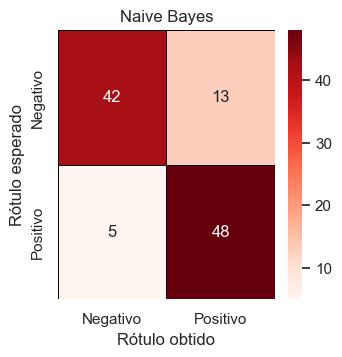

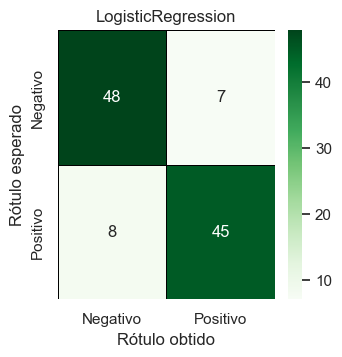

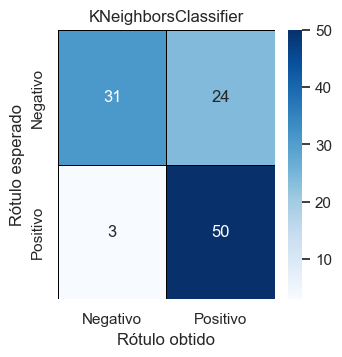

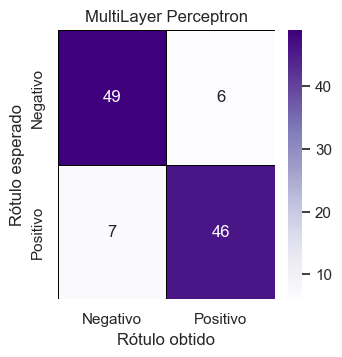

In [64]:
plot_matrix(predicaoNB, 'Reds', 'Naive Bayes')
plot_matrix(predicaoLP, 'Greens', 'LogisticRegression')
plot_matrix(predicaoKNN, 'Blues', 'KNeighborsClassifier')
plot_matrix(predicaoMLP, 'Purples', 'MultiLayer Perceptron')

plt.show()

---
### **Conclusão**

Em análise geral da implementação dos algoritmos, acreditamos ter alcançado resultados satisfatórios em relação as acurácias obtidas pelos algoritmos, principalmente em relação aos algoritmos de MultiLayer Perceptron e Logistic Regression, que obtiveram os melhores resultados dentro dos modelos testados.

Este fator pode ser observado nas matrizes de confusão e tabelas acima, referentes a cada um dos algoritmos desenvolvidos. Este cenário deve-se a 

Tambem podemos concluir que as metricas com a predicao e rotulos de treino trouxeram resultados melhores que as de validacao e teste, fator provavelmente causado por termos separado os datasets de forma aleatoria e os tweets rotulados do treino ficarem melhor rotulados.


